# Hidden Markov Model (HMM): Core Concepts and Elements

A **Hidden Markov Model (HMM)** is a statistical model for sequential data.  
It assumes there is an underlying process that follows a **Markov chain**, but this process is **hidden** and not directly observable.  
Instead, we observe a sequence of **symbols** (or features) generated from these hidden states.

---

## 1. Hidden States (S)
- A finite set of hidden variables that represent the underlying process.  
- Example: Weather = {Sunny, Rainy}.  
- Notation:

$$
S = \{ s_1, s_2, \dots, s_N \}
$$

---

## 2. Observations (O)
- A finite set of symbols we actually observe, emitted from hidden states.  
- Example: Activities = {Walk, Shop, Clean}.  
- Notation:

$$
O = \{ o_1, o_2, \dots, o_M \}
$$

---

## 3. Initial State Distribution (π)
- The probability distribution over states at time \( t = 0 \).  
- Example:

$$
\pi = [0.7, 0.3]
$$

meaning \( P(\text{Sunny}) = 0.7 \), \( P(\text{Rainy}) = 0.3 \).  
- General notation:

$$
\pi_i = P(X_0 = s_i)
$$

---

## 4. Transition Probabilities (A)
- Defines how the hidden state changes over time.  
- Notation:

$$
a_{ij} = P(X_{t+1} = s_j \mid X_t = s_i)
$$

- Properties:

$$
a_{ij} \geq 0, \quad \sum_{j=1}^N a_{ij} = 1
$$

- Example:

$$
A = \begin{bmatrix}
0.8 & 0.2 \\
0.4 & 0.6
\end{bmatrix}
$$

---

## 5. Emission Probabilities (B)
- Defines how observations are generated given the hidden state.  
- Notation:

$$
b_i(o_k) = P(O_t = o_k \mid X_t = s_i)
$$

- Example:

$$
B = \begin{bmatrix}
0.6 & 0.3 & 0.1 \\
0.1 & 0.4 & 0.5
\end{bmatrix}
$$

where each row corresponds to a hidden state and each column to an observation.

---

## 6. Time Parameter (t)
- The model evolves over discrete time steps:

$$
t = 0, 1, 2, \dots, T
$$

- At each step:
  1. The system is in a hidden state \( X_t \).
  2. An observation \( O_t \) is emitted.
  3. The process transitions to the next state using the transition matrix \( A \).

---

## 7. Full Specification of HMM
An HMM is defined by the tuple:

$$
\lambda = (A, B, \pi)
$$

where:
- \( A \): Transition probabilities  
- \( B \): Emission probabilities  
- \( \pi \): Initial distribution  

---

## Summary
- **Markov Chain**: Observed states, defined by \( (S, \pi, A) \).  
- **Hidden Markov Model (HMM)**: Hidden states + observable outputs, defined by \( (S, O, \pi, A, B) \).  

HMMs are widely used in **speech recognition, natural language processing, bioinformatics, finance, and time-series modeling**, where the underlying structure is hidden but can be inferred from observed sequences.


In [9]:
# ===========================================================
# Hidden Markov Model (HMM)
# -----------------------------------------------------------
# Includes:
# - States, Initial Distribution, Transition Matrix
# - Emission Matrix and Observations
# - Sampling Sequences
# - Likelihood Computation (Forward Algorithm)
# - Visualizations (heatmaps, sequences, frequencies, diagrams)
# ===========================================================

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

# -----------------------------
# Hidden Markov Model Class
# -----------------------------
class HiddenMarkovModel:
    def __init__(self, transition_matrix, emission_matrix, initial_probs,
                 state_labels=None, obs_labels=None):
        self.A = transition_matrix
        self.B = emission_matrix
        self.pi = initial_probs
        self.N = transition_matrix.shape[0]
        self.M = emission_matrix.shape[1]
        self.state_labels = state_labels if state_labels else [f"S{i}" for i in range(self.N)]
        self.obs_labels = obs_labels if obs_labels else [f"O{k}" for k in range(self.M)]

    def sample(self, T=10):
        """Generate a sequence of states and observations."""
        states, obs = [], []
        s = torch.multinomial(self.pi, 1).item()
        states.append(s)
        o = torch.multinomial(self.B[s], 1).item()
        obs.append(o)
        for _ in range(T-1):
            s = torch.multinomial(self.A[states[-1]], 1).item()
            states.append(s)
            o = torch.multinomial(self.B[s], 1).item()
            obs.append(o)
        return states, obs

    def sequence_likelihood(self, obs_seq):
        """Forward algorithm: compute P(obs_seq)."""
        T = len(obs_seq)
        alpha = self.pi * self.B[:, obs_seq[0]]
        for t in range(1, T):
            alpha = (alpha @ self.A) * self.B[:, obs_seq[t]]
        return alpha.sum().item()

    def visualize_matrices(self):
        """Visualize Transition and Emission matrices."""
        fig, axs = plt.subplots(1, 2, figsize=(12,5))
        sns.heatmap(self.A.numpy(), annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=self.state_labels, yticklabels=self.state_labels, ax=axs[0])
        axs[0].set_title("Transition Matrix (A)")
        sns.heatmap(self.B.numpy(), annot=True, fmt=".2f", cmap="Greens",
                    xticklabels=self.obs_labels, yticklabels=self.state_labels, ax=axs[1])
        axs[1].set_title("Emission Matrix (B)")
        plt.show()

    def visualize_graph(self):
        """Visualize HMM as a state transition graph with emissions."""
        G = nx.DiGraph()
        for i, si in enumerate(self.state_labels):
            for j, sj in enumerate(self.state_labels):
                if self.A[i,j] > 0.05:  # show only non-trivial transitions
                    G.add_edge(si, sj, weight=round(float(self.A[i,j]),2))
        pos = nx.circular_layout(G)
        plt.figure(figsize=(6,6))
        nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2000, arrowsize=20)
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.title("HMM State Transition Diagram")
        plt.show()

In [11]:
# -----------------------------
# Example Setup: Weather HMM
# -----------------------------
states = ["Sunny", "Rainy"]
observations = ["Walk", "Shop", "Clean"]

A = torch.tensor([[0.8, 0.2],
                  [0.4, 0.6]])  # Transition probabilities
B = torch.tensor([[0.6, 0.3, 0.1],
                  [0.1, 0.4, 0.5]])  # Emission probabilities
pi = torch.tensor([0.7, 0.3])  # Initial distribution

# Create HMM
hmm = HiddenMarkovModel(A, B, pi, state_labels=states, obs_labels=observations)

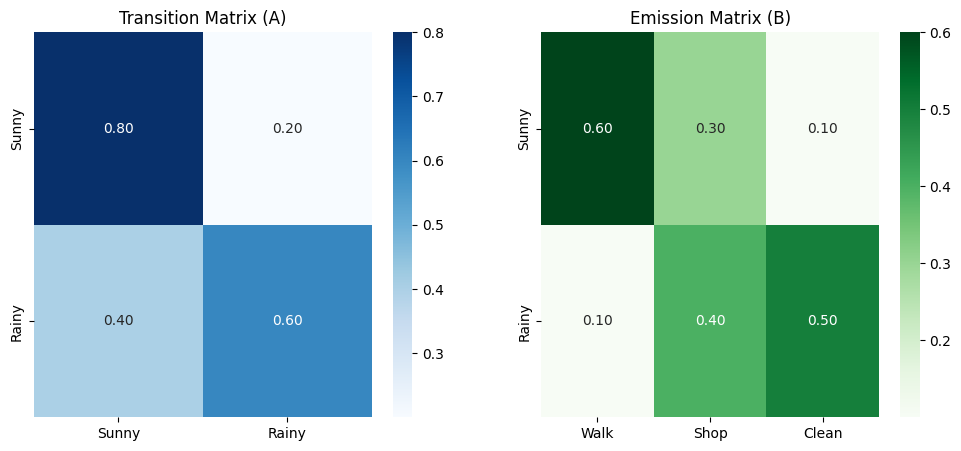

In [12]:
# -----------------------------
# Visualize Matrices
# -----------------------------
hmm.visualize_matrices()

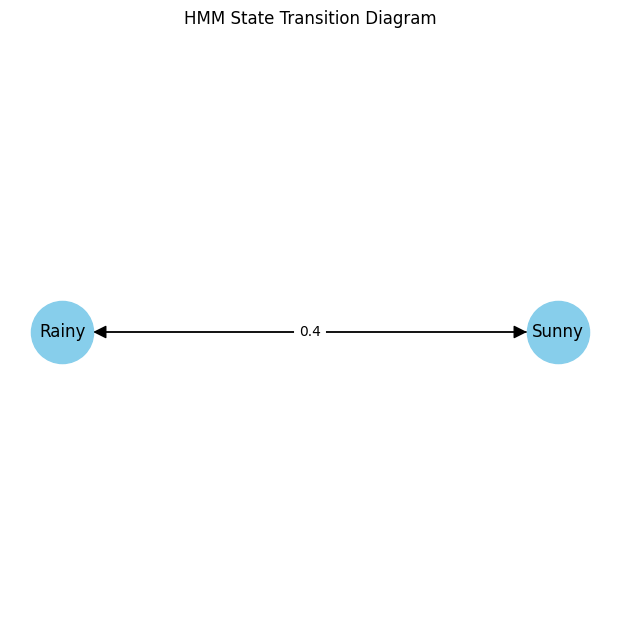

In [13]:
# -----------------------------
# Visualize State Graph
# -----------------------------
hmm.visualize_graph()

In [14]:
# -----------------------------
# Sample Sequences
# -----------------------------
states_seq, obs_seq = hmm.sample(T=12)
print("Hidden States:", [states[s] for s in states_seq])
print("Observations :", [observations[o] for o in obs_seq])

Hidden States: ['Sunny', 'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny']
Observations : ['Shop', 'Shop', 'Walk', 'Shop', 'Clean', 'Walk', 'Walk', 'Walk', 'Walk', 'Walk', 'Shop', 'Clean']


In [15]:
# -----------------------------
# Likelihood of an Observation Sequence
# -----------------------------
test_seq = [0, 1, 2]  # Walk -> Shop -> Clean
likelihood = hmm.sequence_likelihood(test_seq)
print("P(Walk, Shop, Clean) =", likelihood)

P(Walk, Shop, Clean) = 0.03266400098800659


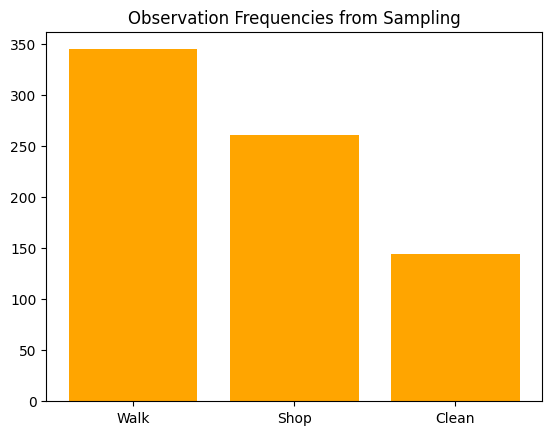

In [16]:
# -----------------------------
# Multiple Sampling and Observation Frequencies
# -----------------------------
all_obs = []
for _ in range(50):
    _, obs_seq = hmm.sample(T=15)
    all_obs.extend([observations[o] for o in obs_seq])

freqs = {obs: all_obs.count(obs) for obs in observations}
plt.bar(freqs.keys(), freqs.values(), color="orange")
plt.title("Observation Frequencies from Sampling")
plt.show()